In [1]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt

### Ⅰ. Batch Normalization

* 각 층의 활성화값 분포를 고르게 하도록 조정
  * 학습 속도가 빨라짐
  * 초기값에 크게 의존하지 않음
  * 오버피팅을 억제 <= 평균과 분산을 하는 과정에서 규제의 효과가 있음
  
$$
\begin{align}
&\mu_B \leftarrow \frac{1}{m}\displaystyle\sum_{i=1}^m x_i\\
&\sigma_B^2 \leftarrow \frac{1}{m}\displaystyle\sum_{i=1}^m(x_i-\mu_B)^2\\
&\hat x_i \leftarrow \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}\\
&y_i \leftarrow \gamma\hat x_i + \beta
\end{align}
$$

<img src='../img/fig 6-16.png'/>

In [2]:
class BatchNormalization:
    """
    http://arxiv.org/abs/1502.03167
    """
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None # 합성곱 계층은 4차원, 완전연결 계층은 2차원  

        # 시험할 때 사용할 평균과 분산
        self.running_mean = running_mean
        self.running_var = running_var  
        
        # backward 시에 사용할 중간 데이터
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg=True):
        self.input_shape = x.shape
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)

        out = self.__forward(x, train_flg)
        
        return out.reshape(*self.input_shape)
            
    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)
                        
        if train_flg:
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc**2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std
            
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var            
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))
            
        out = self.gamma * xn + self.beta 
        return out

    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        dx = self.__backward(dout)

        dx = dx.reshape(*self.input_shape)
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size
        
        self.dgamma = dgamma
        self.dbeta = dbeta
        
        return dx

## Ⅱ. MNIST 데이터셋으로 비교

In [3]:
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)
x_train = x_train[:1000]
t_train = t_train[:1000]

n_iters = 20*10
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01

def compare():
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100],
                                     weight_init_std=0.0858, output_size=10, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100],
                                  weight_init_std=0.0858, output_size=10)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    for i in range(n_iters):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % 10 == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
                
    return train_acc_list, bn_train_acc_list

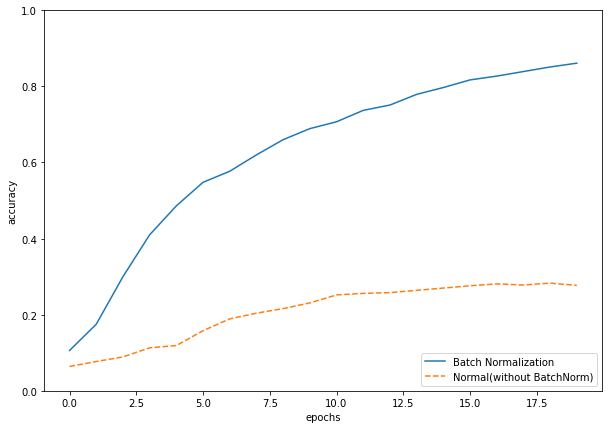

In [4]:
x = np.arange(20)
train_acc_list, bn_train_acc_list = compare()
plt.figure(figsize=(10,7))
plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
plt.ylim(0, 1.0)
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend(loc='lower right')
plt.show()